# Projet de Deep Learning :


=========== projet 6: prediction série temporelle =========

Nous considérons une série temporelle financière donnée de longueur totale N, S_t, t=0,1,...,N.
Nt=0.8*N (entrainement), Nv=0.2*N (validation) à télécharger sur internet ou à prendre une colonne dans 
https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv

Exemple N=255*10 (10 années de données journalières)

On calcule pour chaque point de la série initiale 
- les rendements R_t = np.log(X_t/X_{t-1})
- la moyenne des K derniers rendements, K=5 (=1 semaine: 1W), K=25 (1 mois: 1M), K=3*25 (3M); K=6*25 (6M), K=255 (1Y), K=3Y
- la volatilité (annualisée) des K derniers rendements sur la même période

On ajoute pour chaque point : 
- les calculs précédents (1+7*2 = 15 données)
- le prix en 't', (1 donnée)
- la moyenne exponentielle (EMA) des derniers K prix divisé par le prix en t (7 données)
- une fenetre de longueur "n" des prix S_{t-n} ... S_t,  par exemple n=3*25 (3 mois) : n données .

Attention: parfois il n'est pas possible de calculer par exemple la moyenne sur les 3 dernières année car pas assez de données. Alors la prendre égale à la plus longue qu'il est possible de calculer (ne pas mettre "nan").

Donc la base de données contient N-1 points.
A prevoir: le rendement suivant en R_{t+1}


In [8]:
# 0) Chargement des bibliothèques + seed
# --------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Pour la régression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Pour le réseau de neurones (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Fixation du seed pour la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded and random seed fixed.")



Libraries loaded and random seed fixed.


In [11]:
# 1) Lecture des données (depuis l'URL) et prétraitement
# ------------------------------------------------------

# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes pour plus de clarté
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime (si ce n'est pas déjà le cas)
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

# Affichage des premières lignes et dimensions
print("\nAperçu des premières lignes :")
print(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

# Retirer les lignes contenant des NaN dans la colonne 'Price'
df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

# Vérification après nettoyage
print("\nAperçu après nettoyage :")
print(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :
                Price
Date                 
2000-01-03  16.165972
2000-01-04  15.711578
2000-01-05  15.379528
2000-01-06  14.855226
2000-01-07  15.047465

Dimensions initiales : (8605, 1)

Aperçu après nettoyage :
               Price
Date                
1993-10-18  4.227787
1993-10-19  4.120383
1993-10-20  4.149676
1993-10-21  4.218023
1993-10-22  4.315662

Dimensions après nettoyage : (7339, 1)


In [12]:
# 2) Feature Engineering
# ----------------------
# - Calcul des rendements log (R_t = log(X_t / X_{t-1}))
# - Moyennes mobiles sur K jours, volatilités annualisées
# - EMA (Exponentially Moving Average) / Price
# - Fenêtre glissante (ex. n=5 retards pour la démo)

df = df_raw.copy()

# 2.1 Rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df.dropna(inplace=True)  # retire la première ligne NaN

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 255, 3*255]  # 1W, 1M, 3M, 6M, 1Y, 3Y
# Filtrons si la base est trop courte pour calculer 3 ans
K_list = [K for K in K_list if K < len(df)]

# Calculs (moyenne mobile des rendements + volatilité annualisée)
for K in K_list:
    # Moyenne des K derniers rendements
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)

    # Volatilité annualisée sur K derniers rendements
    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"].fillna(method="bfill", inplace=True)

# 2.3 Ajout du prix en t
df["Price_t"] = df["Price"]

# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"].fillna(method="bfill", inplace=True)

# 2.5 Fenêtre glissante
#   - Par exemple, n=5 (5 retards de prix)
#   - Pour un vrai usage finance, on pourrait prendre n=75 ou 255, etc.
n = 5
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df.dropna(inplace=True)

# 2.6 Cible = Rendement futur R_{t+1}
df["FutureReturn"] = df["Return"].shift(-1)
df.dropna(inplace=True)

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")





Dimensions après feature engineering : (7332, 27)
Feature scaling terminé.


C:\Users\ugo11\AppData\Local\Temp\ipykernel_21876\2245229695.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)
C:\Users\ugo11\AppData\Local\Temp\ipykernel_21876\2245229695.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)
C:\Users\ugo11\AppData\Local\Temp\ipykernel_21876\2245229695.py:27: FutureWarning: A value is trying to

In [15]:
# 3) Séparation temporelle (Train=80%, Test=20%)
# ----------------------------------------------
N = len(df)
Nt = int(0.8 * N)
Nv = N - Nt

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)





Taille dataset complet : 7332
Taille train : 5865
Taille test : 1467



Régression Linéaire - MSE test : 0.000457
Epoch 1/30


c:\Users\ugo11\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0456 - val_loss: 0.0105
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1791e-04 - val_loss: 0.0028
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7133e-04 - val_loss: 0.0027
Epoch 12/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

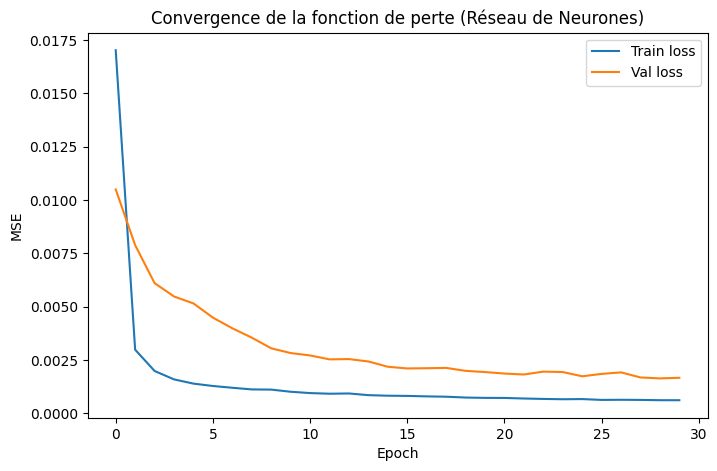

Réseau de Neurones - MSE test : 0.001668


In [16]:
# 4) Modèles : Régression Linéaire et Réseau de Neurones
# ------------------------------------------------------
# 4.1 Régression Linéaire (baseline)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"\nRégression Linéaire - MSE test : {mse_lin:.6f}")

# 4.2 Réseau de Neurones (Keras)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Rendement futur (une valeur)

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,          # vous pouvez ajuster
    batch_size=32,      # vous pouvez ajuster
    verbose=1
)

# Graphique de la convergence de la loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Convergence de la fonction de perte (Réseau de Neurones)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Évaluation du NN
mse_nn = model.evaluate(X_test, y_test, verbose=0)
print(f"Réseau de Neurones - MSE test : {mse_nn:.6f}")




In [17]:
# 5) Étude d'ablation (exemples)
# ------------------------------
# Exemple : a) Retrait des colonnes "emaRatio_*"
mse_ablation = {}

cols_no_ema = [c for c in feature_cols if not c.startswith("emaRatio_")]
X_no_ema = df[cols_no_ema].values
X_no_ema_scaled = scaler.fit_transform(X_no_ema)

X_no_ema_train, X_no_ema_test = X_no_ema_scaled[:Nt], X_no_ema_scaled[Nt:]
y_train2, y_test2 = y_train, y_test

linreg2 = LinearRegression()
linreg2.fit(X_no_ema_train, y_train2)
mse_lin2 = mean_squared_error(y_test2, linreg2.predict(X_no_ema_test))
mse_ablation["NoEMA_LinReg"] = mse_lin2

# b) Retrait des colonnes "meanRet_*"
cols_no_meanRet = [c for c in feature_cols if not c.startswith("meanRet_")]
X_no_meanRet = df[cols_no_meanRet].values
X_no_meanRet_scaled = scaler.fit_transform(X_no_meanRet)

X_no_meanRet_train, X_no_meanRet_test = X_no_meanRet_scaled[:Nt], X_no_meanRet_scaled[Nt:]
linreg3 = LinearRegression()
linreg3.fit(X_no_meanRet_train, y_train2)
mse_lin3 = mean_squared_error(y_test2, linreg3.predict(X_no_meanRet_test))
mse_ablation["NoMeanRet_LinReg"] = mse_lin3

print("\n=== Étude d'ablation ===")
for k, v in mse_ablation.items():
    print(f"{k}: MSE = {v:.6f}")





=== Étude d'ablation ===
NoEMA_LinReg: MSE = 0.000456
NoMeanRet_LinReg: MSE = 0.000458


In [18]:
# 6) Sauvegarde du modèle et des données
# --------------------------------------
os.makedirs("save_model", exist_ok=True)

# Sauvegarde du DataFrame complet
df.to_csv("save_model/my_dataset.csv", index=True)

# Sauvegarde du modèle Keras
model.save("save_model/my_model.h5")

print("\nSauvegarde des données et du modèle terminée.")


# 7) Comparaison finale des performances
# --------------------------------------
print("\n=== Comparaison finale des MSE ===")
print(f"LinReg MSE       : {mse_lin:.6f}")
print(f"NeuralNet MSE    : {mse_nn:.6f}")
print("Ablation exemples : ", mse_ablation)




Sauvegarde des données et du modèle terminée.

=== Comparaison finale des MSE ===
LinReg MSE       : 0.000457
NeuralNet MSE    : 0.001668
Ablation exemples :  {'NoEMA_LinReg': 0.00045590084884430466, 'NoMeanRet_LinReg': 0.0004579277967065355}

Fin du notebook.
